# Classificação de Imagens (Flowers)
## Individual ou em grupo
### André A. Aguiar Gomes - andreaguiar.g@gmail.com

* Crie um notebook chamado VC_1_Lab_06_Flowers_NN.ipynb
* O objetivo é criar um classificador de imagens de flores utilizando Redes Neurais convencionais
* O dataset a ser utilizado é https://www.kaggle.com/alxmamaev/flowers-recognition (também
disponível em https://drive.google.com/file/d/1FcUuwvAO_P-Basmzg_3zdNgwmhiVfABd/view?usp=sharing)
* Copie esse arquivo para seu Drive, descompacte e monte no seu Drive no Google Colab
* Utilize um código como o mostrado no notebook abaixo para criar o dataset de treino e teste:
* https://www.kaggle.com/shreyanshu/flower-classification-model-tensorflow/notebook
* Execute o treinamento variando o pré-processamento da imagem (redução de dimensionalidade,
redução do tamanho, filtros, transformações, quantidade de imagens a serem utilizadas), arquitetura
e hiper parâmetros da rede dentre outros atributos que julgar relevantes
* Obs: Não utilize ainda redes convolucionais: keras.layers.[Conv2D,MaxPool2D]
* Armazene os resultados dos experimentos e explique ao final qual o melhor resultado obtido
* Ao final, salve o Jupyter com a opção Arquivo ➔ Fazer o download do .ipynb
* Após terminar, envie o arquivo para o e-mail jose.junior@prof.unibh.br com o seu nome.

In [1]:
# Import the necessary libraries

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.layers.core import Flatten, Dense, Activation
from keras.layers import Dropout

# Helper libraries
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from os.path import join
import cv2
import pandas
import os
import random
%matplotlib inline

from sklearn.model_selection import train_test_split

In [2]:
# Função para diminuir o height 
def rezise_to_height(img, height):
    
    # Calcula a proporção
    width = int(height * img.shape[1] / img.shape[0])
    
    # Interpola os pixels
    resized = cv2.resize(img, (width, height), interpolation = cv2.INTER_AREA)
    
    # Gera as fatias pretas para completar a imagem quadrada
    sliced = np.zeros((resized.shape[0], (height-resized.shape[1])//2+1, 3), dtype = "uint8")
    
    # Gera as fatias pretas para completar a imagem quadrada
    resized = np.concatenate((sliced,resized,sliced), axis=1)
    return resized


# Função para diminuir o width 
def rezise_to_width(img, width):
    
    # Calcula a proporção
    height = int(width * img.shape[0] / img.shape[1]) 
    
    # Interpola os pixels
    resized = cv2.resize(img, (width, height), interpolation = cv2.INTER_AREA) 
    
    # Gera as fatias pretas para completar a imagem quadrada
    sliced = np.zeros(((width-resized.shape[0])//2+1, resized.shape[1], 3), dtype = "uint8")
    
    # Completa a imagem com preto
    resized = np.concatenate((sliced,resized,sliced), axis=0)
    return resized

In [3]:
# Set o caminho das imagens
data = "flowers/flowers/"

# Lista das pastas no path
folders = os.listdir(data)

print(folders)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [4]:
# Import the images and resize them to a 128*128 size
# Also generate the corresponding labels

image_names = []
train_labels = []
train_images = []

size = 50,50

for folder in folders:
    for file in os.listdir(os.path.join(data,folder)):
        if file.endswith("jpg"):
            image_names.append(os.path.join(data,folder,file))
            train_labels.append(folder)
            img = cv2.imread(os.path.join(data,folder,file))
            
            if img.shape[0] < img.shape[1]:
                im = rezise_to_width(img, size[0])
            elif img.shape[0] > img.shape[1]:
                im = rezise_to_height(img, size[1])
            else:
                im = cv2.resize(img, size, interpolation = cv2.INTER_AREA)
                
            train_images.append(im[0:size[0],0:size[1]])
        else:
            continue
            
# Converte o array de imagem para numpy array
train = np.array(train_images)

train.shape     

(4323, 50, 50, 3)

In [5]:
# Normalizando os valores RGB
train = train.astype('float32') / 255.0

In [6]:
# Extract the labels

label_dummies = pandas.get_dummies(train_labels)

labels =  label_dummies.values.argmax(1)
labels

array([0, 0, 0, ..., 4, 4, 4], dtype=int64)

In [7]:
pandas.unique(train_labels)

array(['daisy', 'dandelion', 'rose', 'sunflower', 'tulip'], dtype=object)

In [8]:
# Shuffle the labels and images randomly for better results
names = train_labels
union_list = list(zip(train, labels))
random.Random(42).shuffle(union_list)
train,labels = zip(*union_list)

# Convert the shuffled list to numpy array type

train = np.array(train)
labels = np.array(labels)

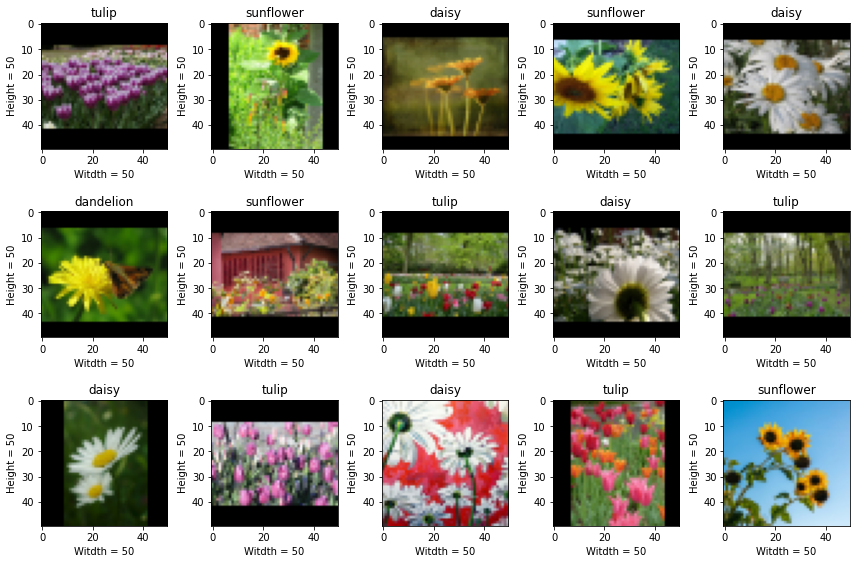

In [9]:
names = {'0':'daisy', '1':'dandelion', '2':'rose', '3':'sunflower', '4':'tulip'}

image = 0
fig, ax = plt.subplots(3,5,figsize=(12,8))
for i in range(0,3):
    for j in range(0,5):
        ax[i,j].imshow(cv2.cvtColor(train[image], cv2.COLOR_BGR2RGB))
        ax[i,j].set(title=f"{names[str(labels[image])]}",
                   xlabel=f"Witdth = {train[image].shape[0]}",
                   ylabel=f"Height = {train[image].shape[1]}")
        image+=1

plt.tight_layout()
plt.show()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    train, labels, random_state=42, test_size=0.25)

In [11]:
X_train.shape, X_test.shape

((3242, 50, 50, 3), (1081, 50, 50, 3))

In [12]:
y_train.shape, y_test.shape

((3242,), (1081,))

In [13]:
tf.random.set_seed(42)

model = keras.Sequential()
model.add(Flatten(input_shape=(size[0],size[1],3)))
model.add(Dense(5))
model.add(Activation('softmax'))

# Compute the model parameters
model.compile(optimizer = Adam(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Train the model  with 5 epochs
model_v1 = model.fit(X_train,y_train, epochs=5,
                     batch_size=128, verbose = 1,
                     validation_split = 0.2)

# Vamos agora avaliar o modelo
score = model.evaluate(X_test, y_test, verbose = 1)

# Imprime a perda e a acurácia
print("\nTest loss:", score[0])
print('Test accuracy:', score[1])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7500)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 37505     
_________________________________________________________________
activation (Activation)      (None, 5)                 0         
Total params: 37,505
Trainable params: 37,505
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
21/21 [==============================] - 0s 18ms/step - loss: 1.6399 - accuracy: 0.2993 - val_loss: 1.4399 - val_accuracy: 0.3652
Epoch 2/5
21/21 [==============================] - 0s 8ms/step - loss: 1.2850 - accuracy: 0.4427 - val_loss: 1.3736 - val_accuracy: 0.4253
Epoch 3/5
21/21 [==============================] - 0s 8ms/step - loss: 1.2146 - accuracy: 0.4848 - val_

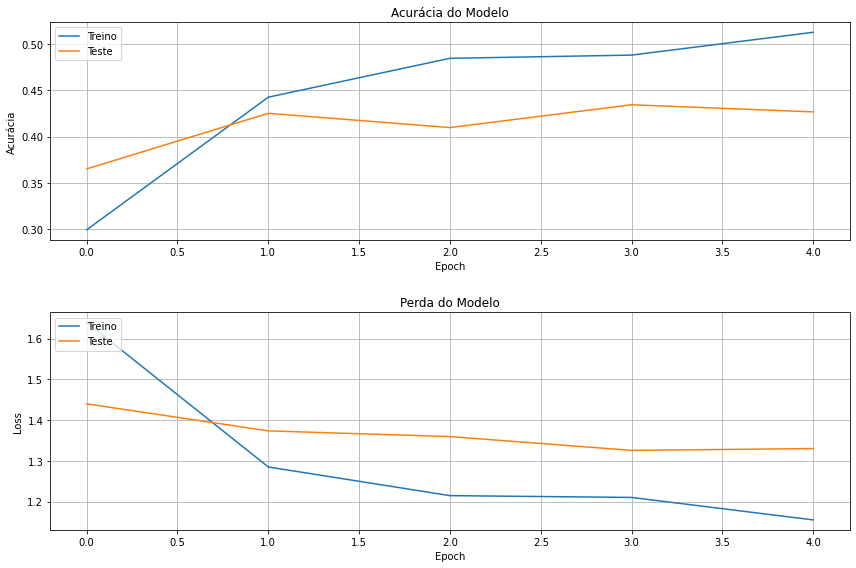

In [14]:
# Em seguida, vamos imprimir os resultados

fig, ax = plt.subplots(2,1, figsize=(12,8))

# Sumariza o modelo para acurácia
ax[0].plot(model_v1.history['accuracy'])
ax[0].plot(model_v1.history['val_accuracy'])
ax[0].set_title('Acurácia do Modelo')
ax[0].set_ylabel('Acurácia')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Treino', 'Teste'], loc = 'upper left')
ax[0].grid()

# Imprime a evolução de erro do modelo
ax[1].plot(model_v1.history['loss'])
ax[1].plot(model_v1.history['val_loss'])
ax[1].set_title('\nPerda do Modelo')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Treino', 'Teste'], loc = 'upper left')
ax[1].grid()

plt.tight_layout()
plt.show()

In [15]:
def set_args(i):
    N_HIDDEN = i
    return N_HIDDEN

def set_model(N_HIDDEN):
    
    NB_CLASSES = 5   # número de classes
    DROPOUT = .1
    
    model = keras.Sequential()
    model.add(Flatten(input_shape=(size[0],size[1],3)))

    model.add(Dense(N_HIDDEN))
    model.add(Activation('relu'))
    model.add(Dropout(DROPOUT))

    model.add(Dense(N_HIDDEN))
    model.add(Activation('hard_sigmoid'))
    model.add(Dropout(DROPOUT))

    model.add(Dense(N_HIDDEN))
    model.add(Activation('tanh'))
    model.add(Dropout(DROPOUT))

    model.add(Dense(NB_CLASSES))
    model.add(Activation('softmax'))
    
    return model
    

In [16]:
test_loss = []
test_accuracy = []
train_loss = []
train_accuracy = []

for i in range(0,101):
    
    tf.random.set_seed(42)
    
    model = set_model(set_args(i))
    # Compute the model parameters
    model.compile(optimizer = Adam(), 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model  with 5 epochs
    model_v1 = model.fit(X_train,y_train, epochs=5,
                         batch_size=128, verbose = 0,
                         validation_split = 0.2)
    
    # Vamos agora avaliar o modelo TRAIN
    score_train = model.evaluate(X_train, y_train, verbose = 0)
    train_loss.append(score_train[0])
    train_accuracy.append(score_train[1])
    
    # Vamos agora avaliar o modelo TEST
    score_test = model.evaluate(X_test, y_test, verbose = 0)
    test_loss.append(score_test[0])
    test_accuracy.append(score_test[1])

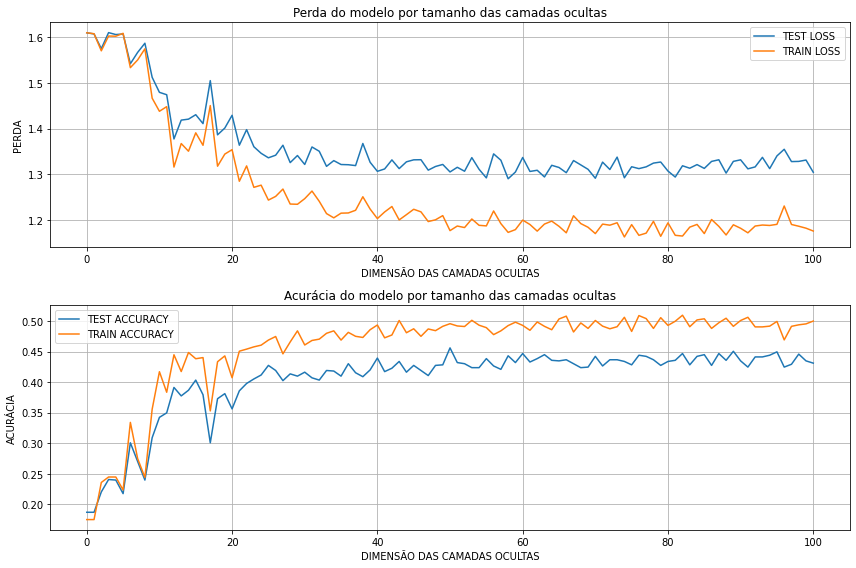

In [17]:
fig, ax = plt.subplots(2,1, figsize=(12,8))

ax[0].plot(test_loss, label="TEST LOSS")
ax[0].plot(train_loss, label="TRAIN LOSS")
ax[0].set_title("Perda do modelo por tamanho das camadas ocultas")
ax[0].set_ylabel("PERDA")
ax[0].set_xlabel("DIMENSÃO DAS CAMADAS OCULTAS")
ax[0].legend()
ax[0].grid()

ax[1].plot(test_accuracy, label="TEST ACCURACY")
ax[1].plot(train_accuracy, label="TRAIN ACCURACY")
ax[1].set_title("Acurácia do modelo por tamanho das camadas ocultas")
ax[1].set_ylabel("ACURÁCIA")
ax[1].set_xlabel("DIMENSÃO DAS CAMADAS OCULTAS")
ax[1].legend()
ax[1].grid()

plt.tight_layout()
plt.show()

In [18]:
test_accuracy.index(max(test_accuracy))

50

In [19]:
test_accuracy[test_accuracy.index(max(test_accuracy))]

0.45605921745300293

In [23]:
tf.random.set_seed(42)

model = set_model(test_accuracy.index(max(test_accuracy)))

# Compute the model parameters
model.compile(optimizer = Adam(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Imprimindo um sumário do modelo de rede neural criado
model.summary()

# Train the model  with 5 epochs
model_v2 = model.fit(X_train,y_train, epochs=5,
                     batch_size=128, verbose = 1,
                     validation_split = 0.2)
# Vamos agora avaliar o modelo
score = model.evaluate(X_test, y_test, verbose = 1)

# Imprime a perda e a acurácia
print("\nTest loss:", score[0])
print('Test accuracy:', score[1])

Model: "sequential_103"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_103 (Flatten)        (None, 7500)              0         
_________________________________________________________________
dense_409 (Dense)            (None, 50)                375050    
_________________________________________________________________
activation_409 (Activation)  (None, 50)                0         
_________________________________________________________________
dropout_306 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_410 (Dense)            (None, 50)                2550      
_________________________________________________________________
activation_410 (Activation)  (None, 50)                0         
_________________________________________________________________
dropout_307 (Dropout)        (None, 50)             

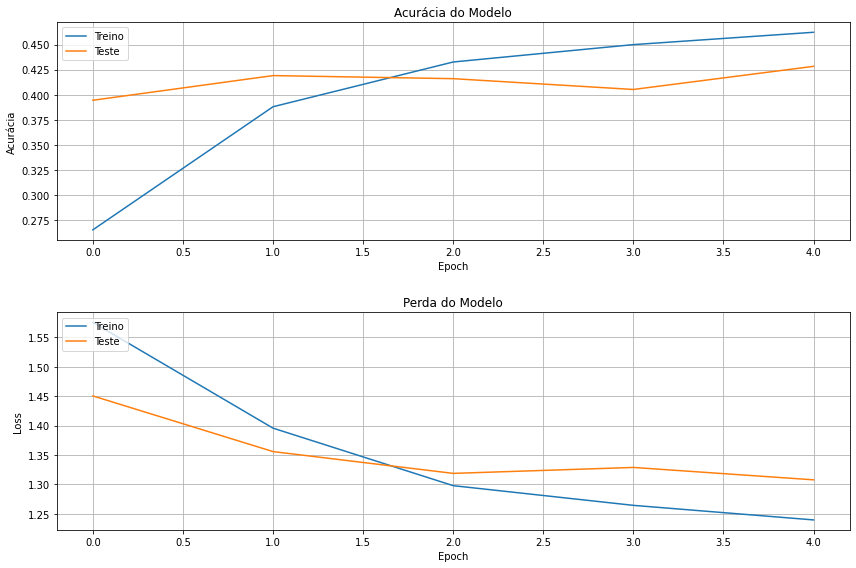

In [24]:
# Em seguida, vamos imprimir os resultados

fig, ax = plt.subplots(2,1, figsize=(12,8))

# Sumariza o modelo para acurácia
ax[0].plot(model_v2.history['accuracy'])
ax[0].plot(model_v2.history['val_accuracy'])
ax[0].set_title('Acurácia do Modelo')
ax[0].set_ylabel('Acurácia')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Treino', 'Teste'], loc = 'upper left')
ax[0].grid()

# Imprime a evolução de erro do modelo
ax[1].plot(model_v2.history['loss'])
ax[1].plot(model_v2.history['val_loss'])
ax[1].set_title('\nPerda do Modelo')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Treino', 'Teste'], loc = 'upper left')
ax[1].grid()

plt.tight_layout()
plt.show()

In [25]:
# Vamos agora avaliar o modelo
score = model.evaluate(X_test, y_test, verbose = 1)

# Imprime a perda e a acurácia
print("\nTest loss:", score[0])
print('Test accuracy:', score[1])

34/34 [==============================] - 0s 2ms/step - loss: 1.3050 - accuracy: 0.4561

Test loss: 1.3050205707550049
Test accuracy: 0.45605921745300293


Após os vários testes executados para classificar o dataset específico, a arquitetura que obteve o melhor desempenho foi com a camada de entrada para alisamento (Flatten), mais 3 camadas densas escondidas com as funçoes de ativação 'relu', 'hard_sigmoid' e 'tanh' respectivamente e 50 neurônios cada, e por fim, a camada de saída 'softmax' com 5 neurônios, relativo à quantidade de classes.
A dificuldade de obter um bom resultado se dá pela falta de padronização dos indivíduos da amostra, tendo algumas imagens com a flor misturada a outras plantas, outras distantes, algumas outras parcialmente cobertas etc.
Há a possibilidade de obter melhores resultados com outros algorítimos e utilizando outras técnicas de pré-processamento das imagens.

# Fim